In [26]:
import pandas as pd
import numpy as np

data = pd.read_csv("../data/adhdata.csv")

# EEG columns
eeg_columns = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']
raw_eeg = data[eeg_columns].values.T  # shape: (channels, samples)
raw_labels = data['Class'].tolist()

In [27]:
#filter and segment
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, low=1, high=30, fs=128):
    nyq = 0.5 * fs
    b, a = butter(5, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

def segment_eeg(eeg, segment_len=384, step=128):
    segments = []
    for start in range(0, eeg.shape[1] - segment_len + 1, step):
        segments.append(eeg[:, start:start+segment_len])
    return segments

In [28]:
#split in segments

from scipy.signal import butter, filtfilt

def bandpass_filter(signal, low=1, high=30, fs=128):
    nyq = 0.5 * fs
    b, a = butter(5, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, signal)

def segment_eeg(eeg, segment_len=384, step=128):
    segments = []
    for start in range(0, eeg.shape[1] - segment_len + 1, step):
        segments.append(eeg[:, start:start+segment_len])
    return segments


In [29]:
#make cwt spectrograms

import pywt
import numpy as np
import cv2
import torch
import torch.nn.functional as F

def morlet_wavelet_bank(scales, size, device):
    t = torch.linspace(-1, 1, steps=size, device=device)
    wavelets = []
    for scale in scales:
        s = float(scale)
        wavelet = torch.exp(2j * np.pi * 1.0 * t) * torch.exp(-t**2 / (2 * (s / 10)**2))
        wavelet = wavelet.real / wavelet.norm()
        wavelets.append(wavelet.view(1, 1, -1))
    return torch.cat(wavelets, dim=0)

def cwt_torch(signal, wavelet_bank):
    signal = signal.to(wavelet_bank.device)
    return F.conv1d(signal, wavelet_bank, padding='same').abs()

In [30]:
import os
import torch
import torch.nn.functional as F
from scipy.signal import butter, filtfilt
from collections import Counter
from tqdm import tqdm

def create_dataset_to_disk(eeg, labels, output_dir, segment_len=384, step=128, scales=np.arange(1, 32)):
    os.makedirs(os.path.join(output_dir, "X"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "y"), exist_ok=True)

    fs = 128
    nyq = 0.5 * fs
    b, a = butter(5, [1 / nyq, 30 / nyq], btype='band')
    eeg_filtered = np.array([filtfilt(b, a, ch) for ch in eeg])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    wavelet_bank = morlet_wavelet_bank(scales, segment_len, device)

    segment_count = (eeg.shape[1] - segment_len) // step + 1

    with tqdm(total=segment_count, desc="Processing segments") as pbar_segments:
        for i, start in enumerate(range(0, eeg.shape[1] - segment_len + 1, step)):
            seg = eeg_filtered[:, start:start + segment_len]
            label_slice = labels[start:start + segment_len]

            ch_specs = []
            for ch in tqdm(seg, desc=f"  CWT channels (segment {i})", leave=False, total=seg.shape[0]):
                ch_tensor = torch.tensor(ch, dtype=torch.float32, device=device).view(1, 1, -1)
                cwt_result = cwt_torch(ch_tensor, wavelet_bank)
                ch_specs.append(cwt_result.squeeze(0).cpu().numpy())

            spec = np.stack(ch_specs, axis=-1)  # (scales, time, channels)
            spec_resized = cv2.resize(spec, (224, 224)).astype(np.float32)
            spec_resized /= spec_resized.max()  # normalize per-segment

            label = Counter(label_slice).most_common(1)[0][0]

            np.save(os.path.join(output_dir, "X", f"{i:05d}.npy"), spec_resized)
            np.save(os.path.join(output_dir, "y", f"{i:05d}.npy"), np.array(label))  # saves string

            pbar_segments.update(1)

    print(f"Finished: {segment_count} spectrograms saved in '{output_dir}'")

create_dataset_to_disk(raw_eeg, raw_labels, output_dir="processed_spectrograms")



Processing segments:   2%|▏         | 413/16922 [00:26<17:47, 15.47it/s]


KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

# ------------------------
# GPU CONFIGURATION
# ------------------------
gpus = tf.config.list_physical_devices('GPU')
print("Devices:", tf.config.list_physical_devices())
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print("GPU config error:", e)
else:
    print("No GPU found — training will run on CPU")

# ------------------------
# Label Map
label_map = {'ADHD': 0, 'Control': 1}
# ------------------------

# Custom Generator with super().__init__ for compatibility
class SpectrogramDataset(Sequence):
    def __init__(self, x_paths, y_paths, batch_size=32, label_map=None, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.batch_size = batch_size
        self.label_map = label_map
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x_paths) / self.batch_size))

    def __getitem__(self, index):
        idxs = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []

        for i in idxs:
            x = np.load(self.x_paths[i])
            y_raw = np.load(self.y_paths[i], allow_pickle=True)
            label = self.label_map[y_raw.item()] if self.label_map and isinstance(y_raw.item(), str) else int(y_raw)
            X.append(x)
            y.append(label)

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ------------------------
# Load file paths
x_dir = "processed_spectrograms/X"
y_dir = "processed_spectrograms/y"

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])
assert len(x_files) == len(y_files), "Mismatch between X and y files"

# ------------------------
# Split dataset
train_x, test_x, train_y, test_y = train_test_split(x_files, y_files, test_size=0.2, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# ------------------------
# Generators
batch_size = 32
train_gen = SpectrogramDataset(train_x, train_y, batch_size=batch_size, label_map=label_map)
val_gen = SpectrogramDataset(val_x, val_y, batch_size=batch_size, label_map=label_map, shuffle=False)
test_gen = SpectrogramDataset(test_x, test_y, batch_size=batch_size, label_map=label_map, shuffle=False)

# ------------------------
# Define ResNet model
def build_resnet(input_shape):
    base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(64, activation='relu')(x)
    out = Dense(2, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=out)

# ------------------------
# Compile & Train
model = build_resnet((224, 224, 19))
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Starting training...")
model.fit(train_gen, validation_data=val_gen, epochs=10, verbose=1)

# ------------------------
# Evaluate
loss, acc = model.evaluate(test_gen, verbose=1)
print(f"Test accuracy: {acc:.4f}")

Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
No GPU found — training will run on CPU


d:\Users\Raphael\Documents\GitHub\ADHD_EEG\my_env\lib\site-packages\keras\src\applications\resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 19 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Starting training...


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set using generator
print("Running predictions on test set...")
y_true, y_pred_cls = [], []

for X_batch, y_batch in test_gen:
    preds = model.predict(X_batch, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    
    y_true.extend(y_batch)
    y_pred_cls.extend(pred_labels)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred_cls = np.array(y_pred_cls)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_cls, target_names=label_map.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_cls)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

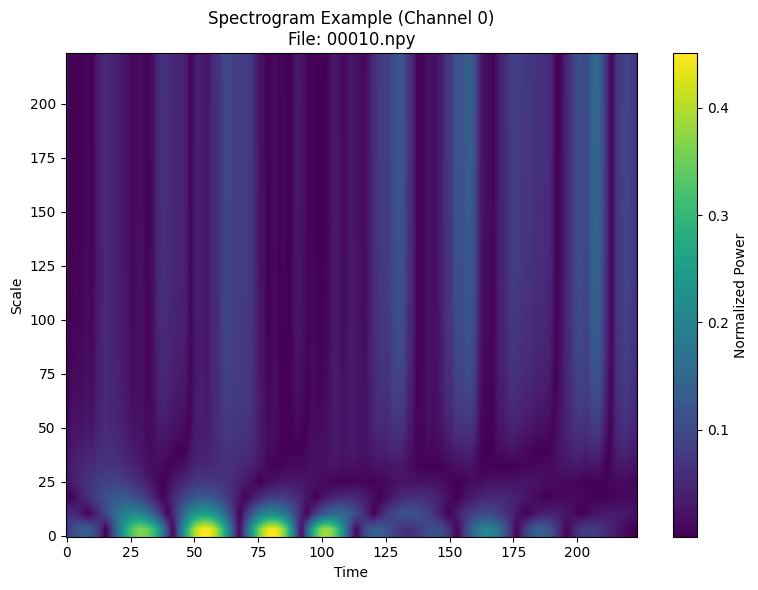

In [3]:
import numpy as np
import os

import matplotlib.pyplot as plt

# Pick a spectrogram file (e.g., the first one)

x_dir = "processed_spectrograms/X"
y_dir = "processed_spectrograms/y"


spec_file = sorted(os.listdir(x_dir))[10]
spec_path = os.path.join(x_dir, spec_file)


# Load the spectrogram
spec = np.load(spec_path)

# Plot the spectrogram (scales x time, for one channel, e.g., channel 0)
plt.figure(figsize=(8, 6))
plt.imshow(spec[:, :, 0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Power')
plt.title(f"Spectrogram Example (Channel 0)\nFile: {spec_file}")
plt.xlabel("Time")
plt.ylabel("Scale")
plt.tight_layout()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow.python.platform import build_info

print("Built with CUDA:", build_info.build_info.get("cuda_version", "Not found"))
print("Built with cuDNN:", build_info.build_info.get("cudnn_version", "Not found"))

print("Available GPUs:", tf.config.list_physical_devices('GPU'))
print("Is GPU available:", tf.test.is_gpu_available(cuda_only=True))

print("TF version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Built with CUDA: Not found
Built with cuDNN: Not found
Available GPUs: []
Is GPU available: False
TF version: 2.15.0
Available GPUs: []
